In [1]:
import ast
import os
#from nn_utils import TrainingHistory
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)
from sklearn import preprocessing
import numpy as np
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split

# Model parameters
MAX_FEATURES = 183312
MAX_TEXT_LENGTH = 1024
EMBED_SIZE  = 100
BATCH_SIZE = 16
EPOCHS = 2
VALIDATION_SPLIT = 0.1

Using TensorFlow backend.


Nous définissons un modèle de classification de texte avec une couche de Conv1D et une couche de Dense. Nous pouvons utiliser les vecteurs de mots pré-appris. Le modèle est basé sur le [TP de M. Kermorvant](https://gitlab.com/kermorvant/nlp-labs).

In [14]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH)

    
def get_model(embedding_matrix, word_index):

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    #modification here
    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(11, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y_train):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1)

    return model.predict(x_test)

Nous lisons le jeu de données d'apprentissage et de test.

In [3]:
x_train = []
y_train = []
x_test = []
y_test = []
with open('datasets/news_less_category.txt', 'r') as f:
    for line in f:
        temp = line.split('__label__')
        x_train.append(temp[0])
        y_train.append(temp[1])
with open('datasets/news_fasttext_test.txt', 'r') as f:
    for line in f:
        temp = line.split('__label__')
        x_test.append(temp[0])
        y_test.append(temp[1])

Si l'on définit les jeux de données d'apprentissage et test comme ça, la taille de jeux de données est super élevée. Dans ce cas-là, le temps de calcul va exploser. Nous décidons de prendre le jeu de données de test, puis faire le découpage afin d'obtenir le jeu de données d'apprentissage utilisé et le jeu de données de test utilisé.

In [10]:
def split_datasets(data_path, test_size):
    x = []
    y = []
    with open(data_path, 'r') as f:
        for line in f:
            temp = line.split('__label__')
            x.append(temp[0])
            y.append(temp[1].replace('\n', ''))
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    print('Dataset splited.')
    return x_train, x_test, y_train, y_test

Maintenant nous allons lire les vecteurs de mots pré-appris. Cette partie est basé sur le [tutoriel de Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) 

In [6]:
embeddings_index = {}
with open('model_pure_skip.vec', 'r') as f:
    first_line = f.readline()
    print(first_line)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


print('Found %s word vectors.' % len(embeddings_index))

183312 100

Found 183312 word vectors.


In [15]:
def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(x_train, embedding_index):
    print('Building embedding matrix...')  
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
    tokenizer.fit_on_texts(x_train)
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix, word_index

In [9]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Nous allons d'abord tokenizer les données au format pour le réseau de neurones

In [7]:
# TODO:
# Get the list of different classes
CLASSES_LIST = np.unique(y_train)
n_out = len(CLASSES_LIST)
print(CLASSES_LIST)

# Convert class string to index
le = preprocessing.LabelEncoder()
le.fit(CLASSES_LIST)
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
train_y_cat = np_utils.to_categorical(y_train, n_out)

# get the textual data in the correct format for NN
x_vec_train, x_vec_test = get_train_test(x_train, x_test)
print(len(x_vec_train), len(x_vec_test))

['affairs\n' 'economic\n' 'edu\n' 'ent\n' 'fashion\n' 'game\n' 'home\n'
 'house\n' 'science\n' 'sports\n' 'stock\n']
109989 103369


In [16]:
def class_str_2_ind(x_train, x_test, y_train, y_test):
    le = preprocessing.LabelEncoder()
    CLASSES_LIST = np.unique(y_train)
    n_out = len(CLASSES_LIST)
    print(CLASSES_LIST)
    print('Converting data to trainable form...')
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test = get_train_test(x_train, x_test)
    print(len(x_vec_train), len(x_vec_test))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat

----
Nous entraînons le modèle.

In [ ]:
vectors_file_path = 'word2vec_skip.txt'
data_path = 'datasets/news_fasttext_test.txt'
test_size = 0.01
x_train, x_test, y_train, y_test = split_datasets(data_path, test_size)
x_vec_train, x_vec_test, y_train, y_test, train_y_cat = class_str_2_ind(x_train, x_test, y_train, y_test)

In [17]:
embedding_index = get_embedding_index(vectors_file_path)
embedding_matrix, word_index = get_embedding_matrix(x_train, embedding_index)
model = get_model(embedding_matrix, word_index)
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))

183311 100

Found 183311 word vectors.
Building embedding matrix...
Embedding matrix built.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1024, 100)         50480200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 32)          6432      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (Non

In [10]:
def main():
    # define the NN topology
    model = get_model(embedding_matrix)

    # Define training procedure
    #history = TrainingHistory(x_vec_test, y_test, CLASSES_LIST)

    # Train and predict
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)


    print("Test Accuracy:", accuracy_score(y_test, y_predicted))

    p, r, f1, s = precision_recall_fscore_support(y_test, y_predicted, 
                                                  average='micro',
                                                  labels=[x for x in 
                                                          np.unique(y_train) 
                                                          if x not in ['CSDECMOTV']])

    print('p r f1 %.1f %.2f %.3f' % (np.average(p, weights=s)*100.0, 
                                     np.average(r, weights=s)*100.0, 
                                     np.average(f1, weights=s)*100.0))


    print(classification_report(y_test, y_predicted, labels=[x for x in 
                                                           np.unique(y_train) 
                                                           if x not in ['CSDECMOTV']]))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1024, 100)         52613700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 32)          6432      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
___________________________________________________________

----
Nous allons plotter la matrice de confusion, code basé sur [l'exemple de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from plot_util import plot_confusion_matrix
%matplotlib inline

In [21]:
np.save('y_predicted', y_predicted)
np.save('y_test', y_test)

In [4]:
import numpy as np
y_predicted = np.load('y_predicted.npy')
y_test = np.load('y_test.npy')

Confusion matrix, without normalization
Normalized confusion matrix
[ 0  1  2  3  4  5  6  7  8  9 10]



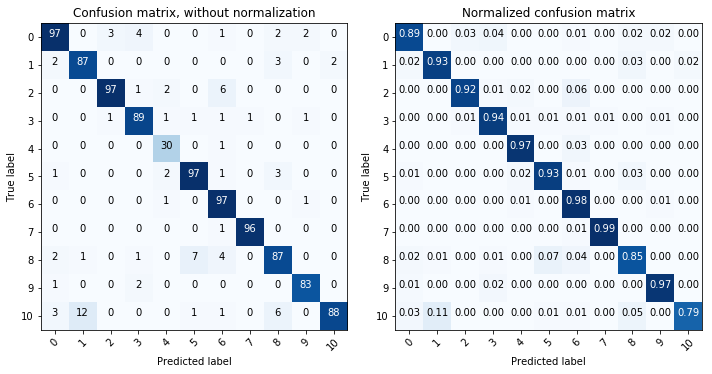

In [6]:
CLASSES_LIST = np.unique(y_test)
class_names = np.unique(CLASSES_LIST)
conf_mat = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, class_names, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, class_names, normalize=True, title='Normalized confusion matrix')
print(class_names)
print()